# Segmentación de clientes

El objetivo es encontrar segmentos (grupos) de clientes minoristas en función de su patrón de consumo anual en diversas categorías de productos[here](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers).

In [134]:
import seaborn as sns
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import MeanShift, estimate_bandwidth

import matplotlib.cm as cm

In [ ]:
import pandas as pd
customers = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectWC/data/wholesale_customers_data.csv")
customers.head()

## Visualización de los datos

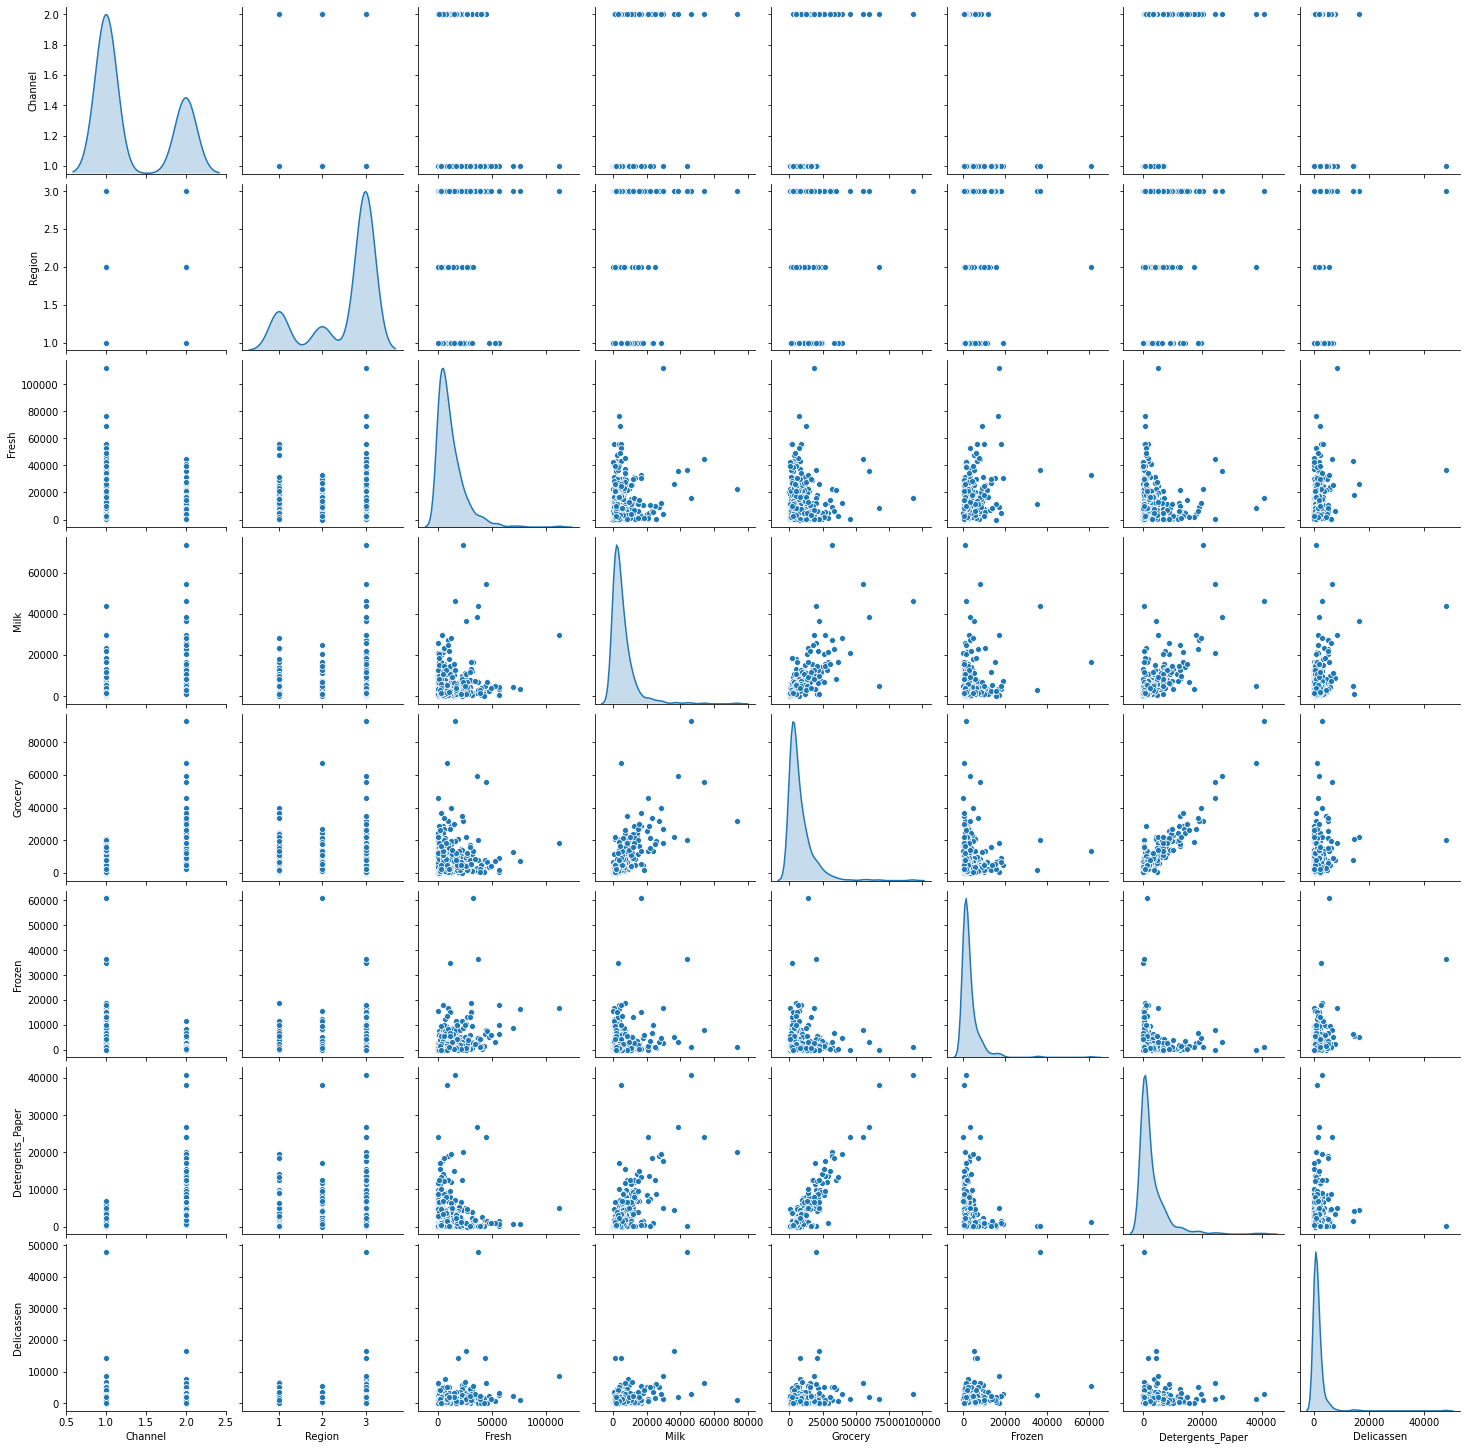

In [3]:
sns.pairplot(customers, diag_kind="kde")

In [4]:
#KMeans?
customers.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


**Se observan que hay algunos valores que parecen outliers, dado que no conozco muy bien los datos que estoy utilizando no los voy a filtrar por que por ahí sirven para algo... Debería de probar filtrandolos...**

**También se puede observar que los valores son muy altos, tengo que aplicar algún escalado de los mismos**

## Preprocesamiento 

**En esta instancia solo escalo los datos con StandardScaler, queda pendiente la eliminación de outliers, así como analizar si alguna de las caracteristicas es poco relevante para la segmentación**

In [73]:
#Pruebo escalando los datos.
scaler = StandardScaler()
cc = scaler.fit_transform(customers)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
customers_prepared = pd.DataFrame(cc, columns=customers.columns)
customers_prepared.head(10)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1.448652,0.590668,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339
1,1.448652,0.590668,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151
2,1.448652,0.590668,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293
3,-0.690297,0.590668,0.100111,-0.624020,-0.392977,0.687144,-0.498588,0.093411
4,1.448652,0.590668,0.840239,-0.052396,-0.079356,0.173859,-0.231918,1.299347
5,1.448652,0.590668,-0.204806,0.334067,-0.297637,-0.496155,-0.228138,-0.026224
6,1.448652,0.590668,0.009950,-0.352316,-0.102849,-0.534512,0.054280,-0.347854
7,1.448652,0.590668,-0.349981,-0.113981,0.155359,-0.289315,0.092286,0.369601
8,-0.690297,0.590668,-0.477901,-0.291409,-0.185336,-0.545854,-0.244726,-0.275079
9,1.448652,0.590668,-0.474497,0.718495,1.151423,-0.394488,0.954031,0.203461


In [139]:
def plot_2d_features(estimator, data):
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    label = estimator.predict(data)
    centroids = estimator.cluster_centers_
    
    color=['red','green','blue','yellow','cyan', 'orange','black','purple', 'gray', 'brown', 'black','purple', 'gray', 'brown', 'black','purple', 'gray', 'brown']
    color = color[0:centroids.shape[0]]
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

    plt.plot(data[:, 0], data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X


    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color=color, zorder=10)
    
    plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

## KMeans

**Realizo la segmentación con KMeans probando con diferentes clausters, para evaluar la performance con cada uno de los valores de n_clusters utilizaré silhouette_score y Inertia los cuales he encontrado que son los recomendados en la documentación de sklearn**

For n_clusters = 2 The average silhouette_score is : 0.37323636511581165


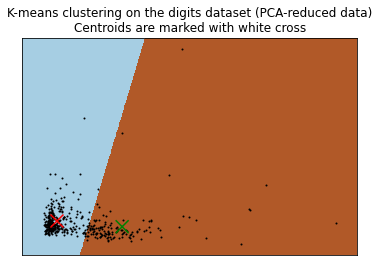

For n_clusters = 3 The average silhouette_score is : 0.3567685389017652


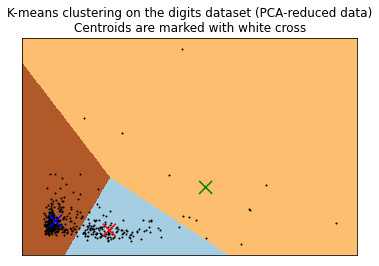

For n_clusters = 4 The average silhouette_score is : 0.34782361136344925


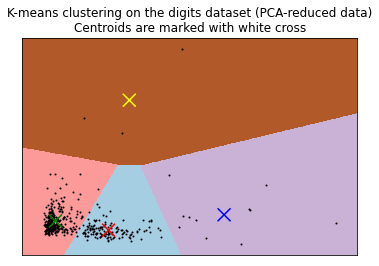

For n_clusters = 5 The average silhouette_score is : 0.35092027274262044


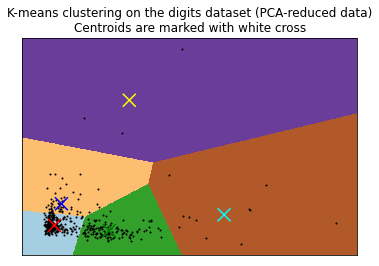

For n_clusters = 6 The average silhouette_score is : 0.354872768644064


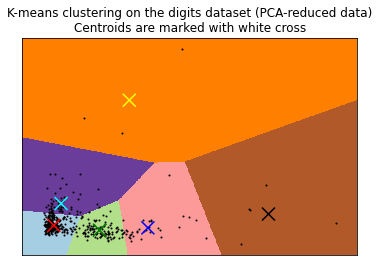

For n_clusters = 7 The average silhouette_score is : 0.36133804570510175


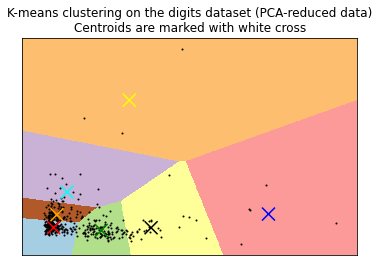

For n_clusters = 8 The average silhouette_score is : 0.3567617118456414


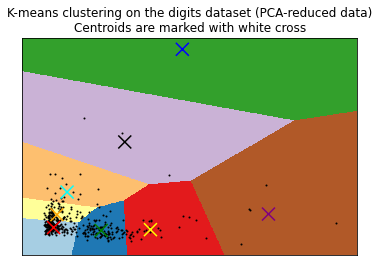

For n_clusters = 9 The average silhouette_score is : 0.35554346487624106


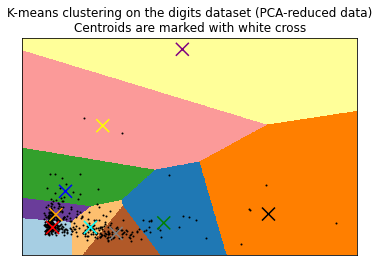

For n_clusters = 10 The average silhouette_score is : 0.35959548671435315


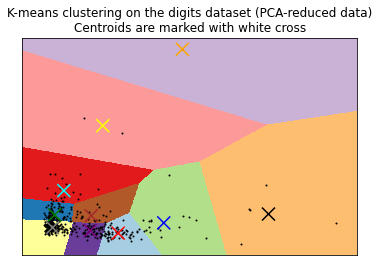

In [123]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
elbow = []
ss = []
for n_clusters in range_n_clusters:

    clusterer = KMeans(init='k-means++',n_clusters = n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(customers_prepared)

    silhouette_avg = silhouette_score(customers_prepared, cluster_labels)
    ss.append(silhouette_avg)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)
    #Finding the average SSE"
    elbow.append(clusterer.inertia_) # Inertia: Sum of distances of samples to their closest cluster center
    
    #Reduzco a dos componentes para ver la segmentación
    reduced_data = PCA(n_components=2).fit_transform(customers_prepared)
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters )
    kmeans.fit(reduced_data)
    plot_2d_features(kmeans, reduced_data)


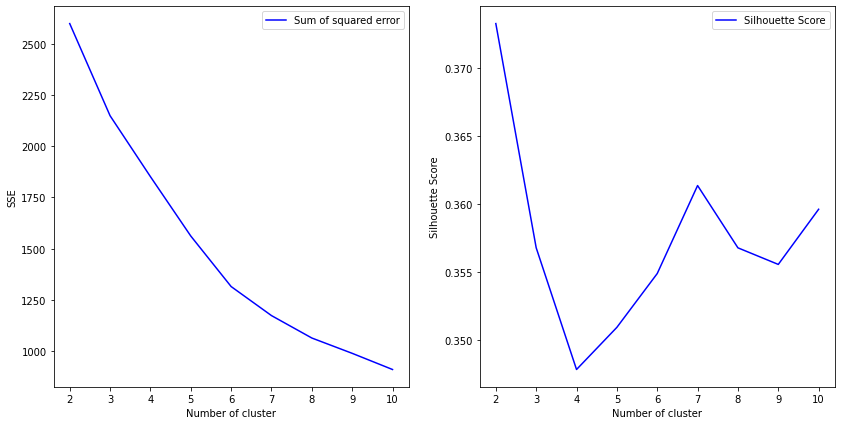

In [85]:
#Grafico los valores los indicadores
fig = plt.figure(figsize=(14,7))
fig.add_subplot(121)
plt.plot(range_n_clusters, elbow,'b-',label='Sum of squared error')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.legend()
fig.add_subplot(122)
plt.plot(range_n_clusters, ss,'b-',label='Silhouette Score')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

**En la bibliográfia recomiendan tomar como valor de clauster el valor el "codo" del gráfico de SSE. Se determina que el número de clauster óptimo es 6**

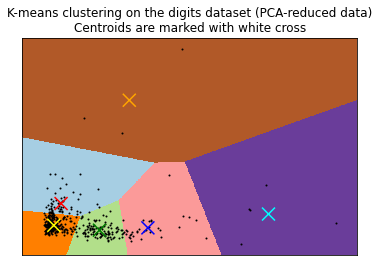

In [141]:
#Con valor 6
clusterer = KMeans(n_clusters=6, random_state=10)
cluster_labels = clusterer.fit_predict(customers_prepared)

#Reduzco a dos componentes para ver la segmentación
reduced_data = PCA(n_components=2).fit_transform(customers_prepared)
kmeans = KMeans(init='k-means++', n_clusters=6 )
kmeans.fit(reduced_data)
plot_2d_features(kmeans, reduced_data)

In [128]:
#Clases 3 y 4 outliers

/home/marian/.local/lib/python3.6/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/marian/.local/lib/python3.6/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/marian/.local/lib/python3.6/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


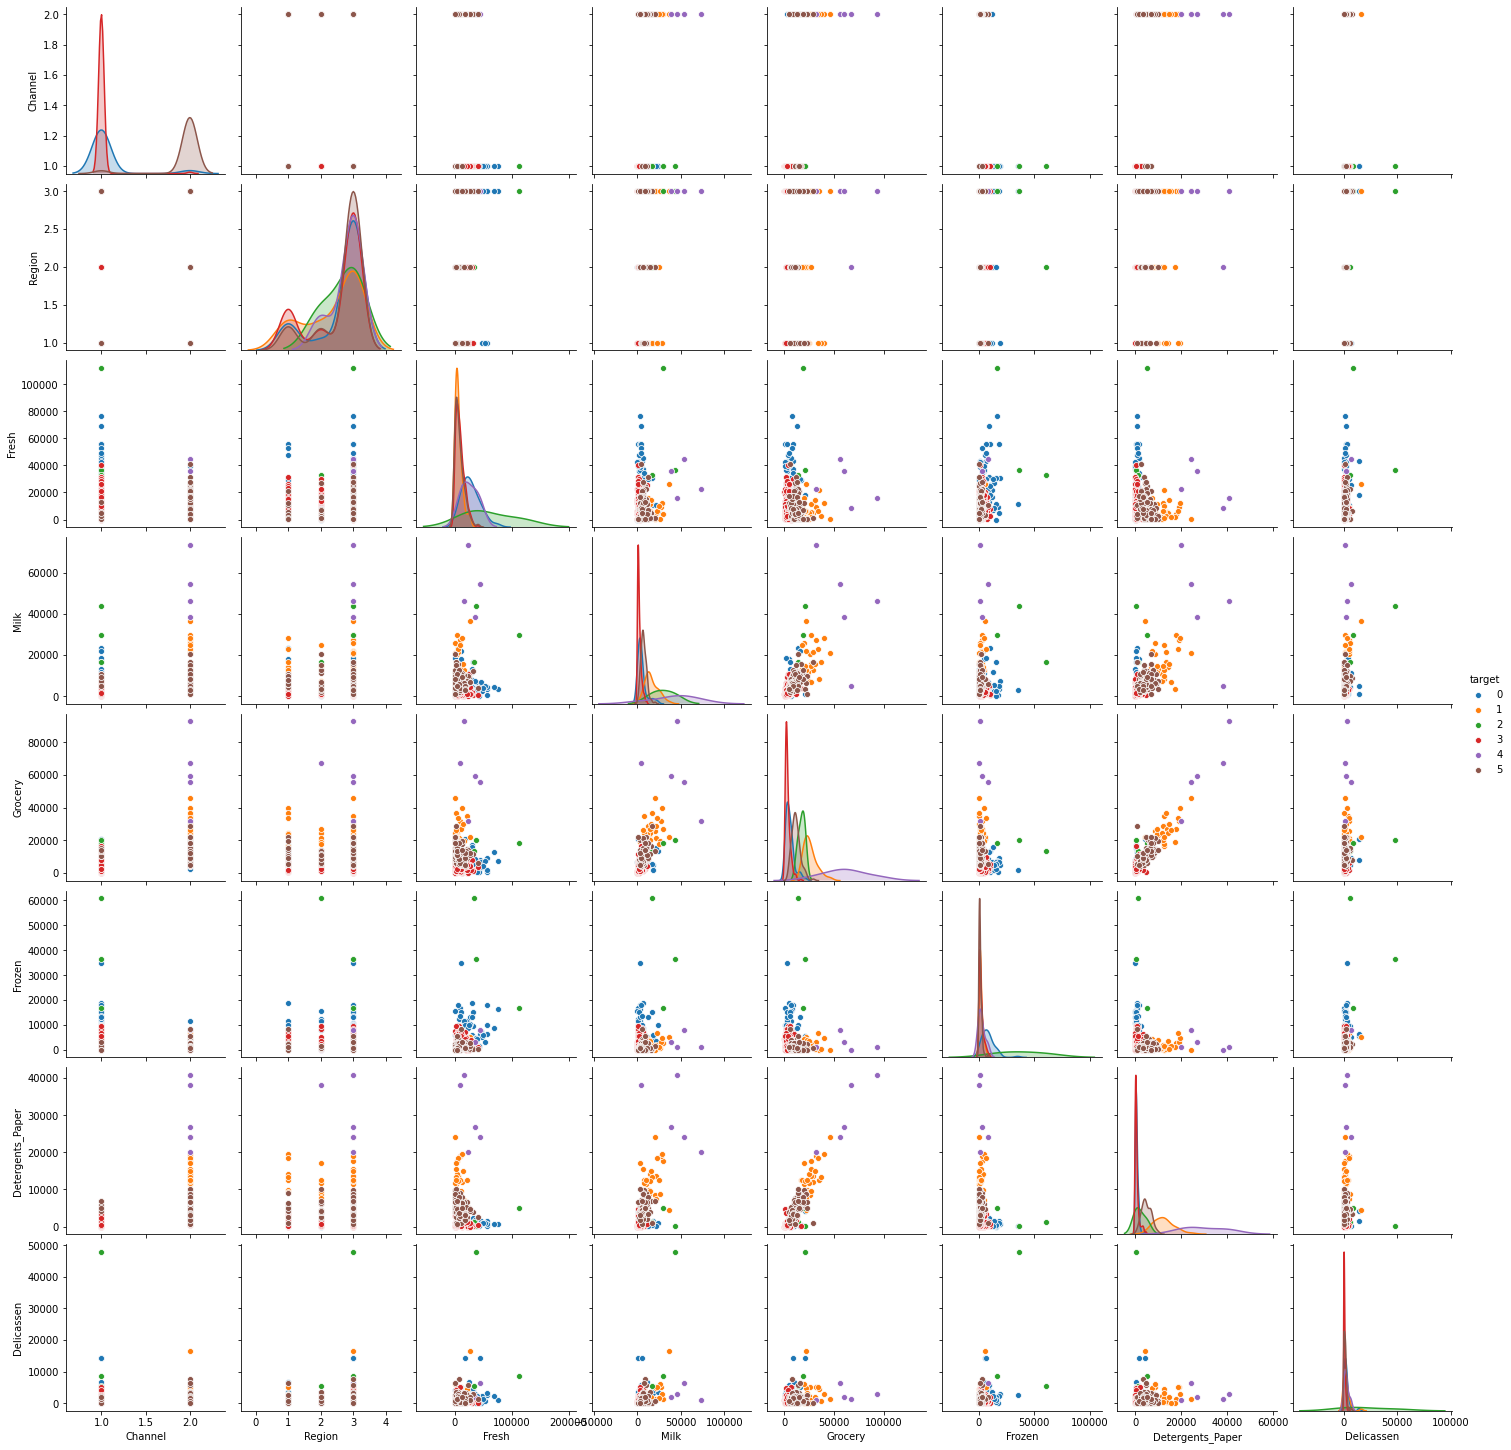

In [133]:
customers_view = customers.copy()
customers_view['target'] = cluster_labels
sns.pairplot(customers_view, hue='target')

**Algunas cosas se pueden observar: Las clases 2 y 4 segmentaron los outliers... Grocery es una caracteristica importante para segmentación de los consumidores... La clase 1 tiene a los consumidores que compran más Detergents_paper, grocery y milk** 

## Mean Sheaft

number of estimated clusters : 16


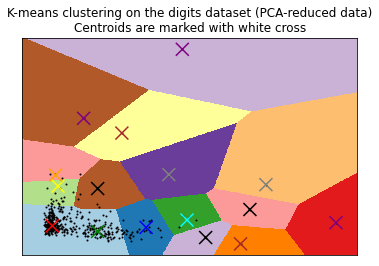

number of estimated clusters : 12


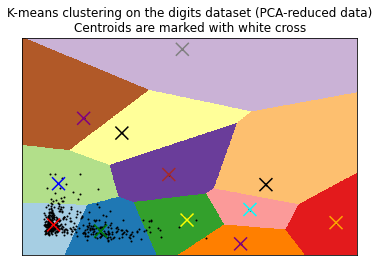

number of estimated clusters : 11


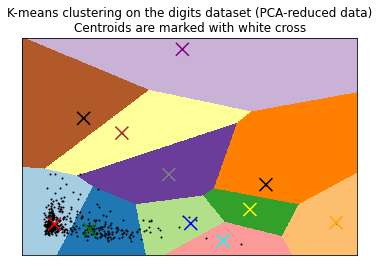

number of estimated clusters : 8


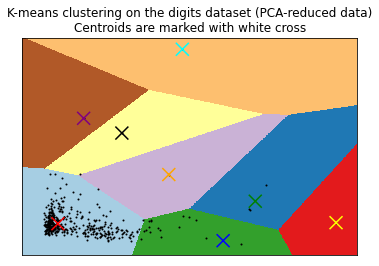

number of estimated clusters : 7


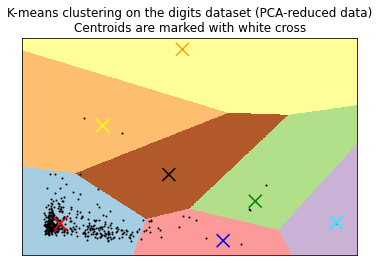

number of estimated clusters : 6


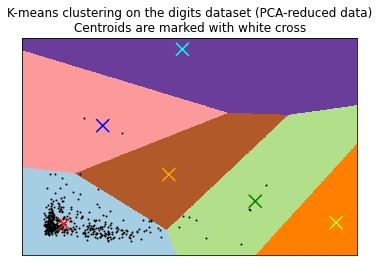

number of estimated clusters : 6


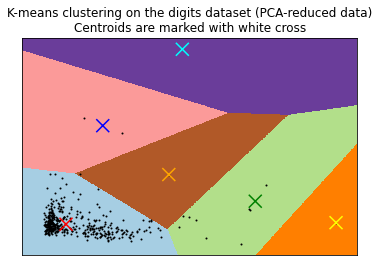

number of estimated clusters : 5


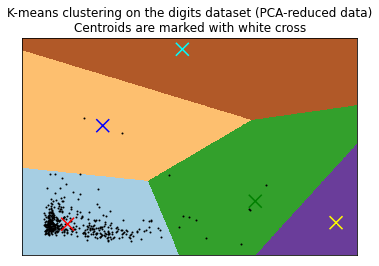

number of estimated clusters : 2


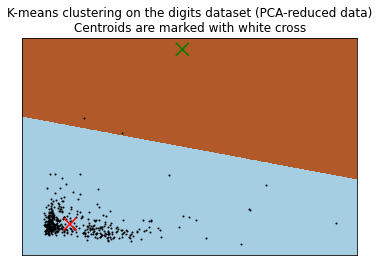

In [140]:
#Mean Sheaft
rango = np.arange(0.1,1,0.1)

ss = []

for quantile in rango:
    bandwidth = estimate_bandwidth(reduced_data, quantile=quantile)
    ms=MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(reduced_data)

    labels = ms.labels_
    cluster_centers = ms.cluster_centers_

    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)

    silhouette_avg = silhouette_score(customers, labels)
    
    ss.append(silhouette_avg)
    print("number of estimated clusters : %d" % n_clusters_)

    #Reduzco a dos componentes para ver la segmentación
    reduced_data = PCA(n_components=2).fit_transform(customers_prepared)
    mean_sh = MeanShift(bandwidth=bandwidth, bin_seeding=True )
    mean_sh.fit(reduced_data)
    plot_2d_features(mean_sh, reduced_data)


**La Segmentación con Mean Shift no parece tener buen resultado para este dataset**